In [1]:
using Turing, Distributions


# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

# Functionality for splitting and normalizing the data
# using MLDataUtils: shuffleobs, stratifiedobs, rescale!

# Set a seed for reproducibility.
using Random
Random.seed!(0);

using StatsBase
using DataFrames
import CSV
import MLJBase
using MLJ
setprogress!(true)

WebIO._IJuliaInit()

┌ Info: [Turing]: progress logging is enabled globally
└ @ Turing /Users/alexpanchot/.julia/packages/Turing/uMQmD/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as true
└ @ AdvancedVI /Users/alexpanchot/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


true

In [2]:
MissingImputator = @load MissingImputator pkg="BetaML"

LoadError: UndefVarError: iris not defined

In [247]:
iris = CSV.read("iris.csv",DataFrame,stringtype=String)
filter!(x->x.class != "Iris-virginica",iris)

MLJBase.coerce!(iris,:class=>MLJBase.OrderedFactor)
iris.class = [i=="Iris-setosa" ? true : false for i in iris.class]
y,x=MLJBase.unpack(iris,
    ==(:class),colname -> true );

# x = DataFrames.select(iris, DataFrames.Not(:class))
# y = iris.class
# y = [i=="Iris-setosa" ? true : false for i in y]

In [252]:
train, test = MLJBase.partition(eachindex(y), 0.03, stratify=y,  shuffle=true)

([47, 25, 58, 81], [18, 6, 96, 69, 67, 10, 41, 86, 7, 91  …  66, 87, 51, 79, 39, 65, 40, 73, 55, 21])

In [253]:
transform_standardizer!(x,fit_standardizer(x[train,:])); # comes from pred_funcs

In [254]:
allowmissing!(x);

In [274]:
perc_missing = 0.10
nn=round(Int,perc_missing*400); # create abritrary missing
yrand = rand(1:ncol(x),nn);
xrand = rand(1:nrow(x),nn);

In [277]:

xnew = copy(x)
for i in 1:nn
    xnew[xrand[i],yrand[i]] = missing
end
stmach = machine(MissingImputator(K=7,mixtures=:spherical_gaussian),xnew) 
sttran = fit!(stmach,verbosity=0)
tt = MLJ.transform(sttran,xnew)
for i in 1:ncol(xnew)
    xnew[:,i] = tt[i]
end
println(sum(Matrix(abs.(xnew.-x)))/nn)


0.4887480660731397


In [268]:
? MissingImputator

search: MissingImputator



No documentation found.

# Summary

```
mutable struct BetaML.Clustering.MissingImputator <: Unsupervised
```

# Fields

```
K             :: Int64
p₀            :: Union{Nothing, AbstractVector{Float64}}
mixtures      :: Symbol
tol           :: Float64
minVariance   :: Float64
minCovariance :: Float64
initStrategy  :: String
rng           :: AbstractRNG
```

# Supertype Hierarchy

```
BetaML.Clustering.MissingImputator <: Unsupervised <: MLJModelInterface.Model <: MLJModelInterface.MLJType <: Any
```


In [290]:
@model function logistic_regression(x, y, n, σ)
    intercept ~ Normal(0, σ)

    sepal_length ~ Normal(0, σ)
    sepal_width  ~ Normal(0, σ)
    petal_length ~ Normal(0, σ)
    petal_width  ~ Normal(0, σ)

    for i = 1:n
        v = logistic(intercept + sepal_length*x[i, 1] + sepal_width*x[i,2] + petal_length*x[i,3] + petal_width*x[i,4] )
        y[i] ~ Bernoulli(v)
    end
end;

In [293]:
n = length(y[train])

# Sample using HMC.
m = logistic_regression(xnew[train,:], y[train], n, 1)
chain = sample(m, HMC(0.05, 10), MCMCThreads(), 1000, 3)

describe(chain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (5 x 8)
 Quantiles (5 x 6)

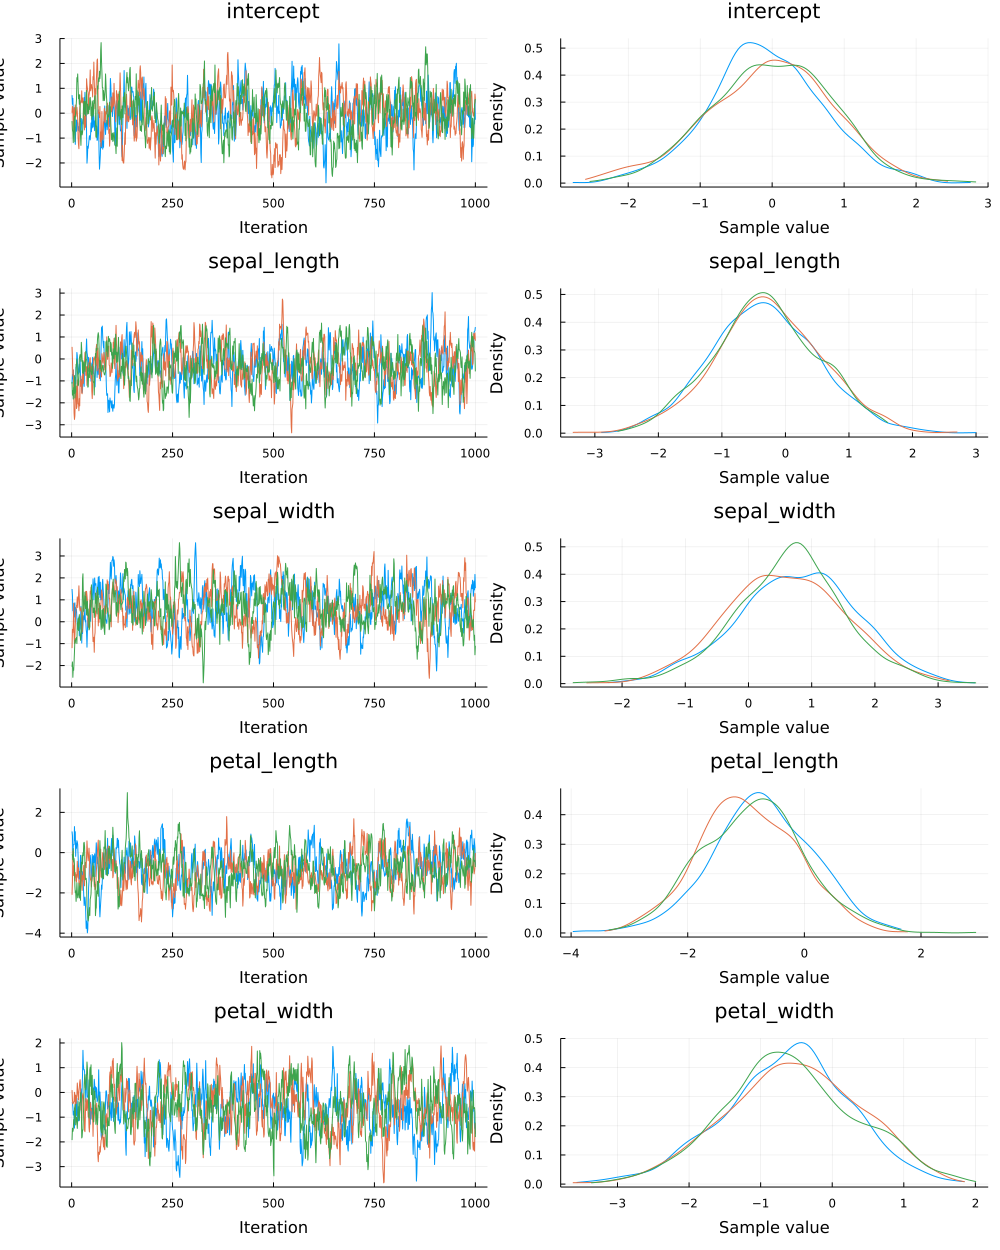

In [294]:
plot(chain)

In [260]:
function prediction(x, chain)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept])
    sepal_length = mean(chain[:sepal_length])
    sepal_width = mean(chain[:sepal_width])
    petal_length = mean(chain[:petal_length])
    petal_width = mean(chain[:petal_width])

    # Retrieve the number of rows.
    n = nrow(x)

    # Generate a vector to store our predictions.
    v = Vector{Float64}(undef, n)

    # Calculate the logistic function for each element in the test set.
    for i in 1:n
        v[i] = logistic(intercept + sepal_length*x[i, 1] + sepal_width*x[i,2] + petal_length*x[i,3] + petal_width*x[i,4] )
    end
    return v
end;

In [261]:
ypred = prediction(xnew[test,:],chain)

96-element Vector{Float64}:
 0.8307194770543331
 0.770976825881327
 0.049525300329193854
 0.009559114122165601
 0.017109387412351067
 0.8478895714597158
 0.8577044204597878
 0.023032861217983595
 0.9031166297038745
 0.058154878462735655
 0.03253439509052711
 0.863171426589724
 0.06919902677953771
 ⋮
 0.8983900016922435
 0.014900629547496902
 0.012779088574139464
 0.009421035621124597
 0.0076081269066324226
 0.025635365824652083
 0.912530910102972
 0.08986936348837471
 0.8279550042522564
 0.013778380095945859
 0.010131640714863818
 0.7336141140390606

In [262]:
yhat = [i>.5 ? true : false for i in ypred];

In [263]:
y[test];

In [264]:
MLJ.ConfusionMatrix()(yhat,y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='false' and positive='true'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /Users/alexpanchot/.julia/packages/MLJBase/W4gFl/src/measures/confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │    false    │    true     │
├─────────────┼─────────────┼─────────────┤
│    false    │     48      │      0      │
├─────────────┼─────────────┼─────────────┤
│    true     │      0      │     48      │
└─────────────┴─────────────┴─────────────┘


In [265]:
? fit!

search: fit! filter! popfirst! pushfirst! fit_only! portfoliocomposition! fit



Fit a statistical model in-place.

---

```
fit!(mach::Machine, rows=nothing, verbosity=1, force=false)
```

Fit the machine `mach`. In the case that `mach` has `Node` arguments, first train all other machines on which `mach` depends.

To attempt to fit a machine without touching any other machine, use `fit_only!`. For more on the internal logic of fitting see [`fit_only!`](@ref)

---

```
fit!(N::Node;
     rows=nothing,
     verbosity=1,
     force=false,
     acceleration=CPU1())
```

Train all machines required to call the node `N`, in an appropriate order.  These machines are those returned by `machines(N)`.

---

```
fit!(mach::Machine{<:Surrogate};
     rows=nothing,
     acceleration=CPU1(),
     verbosity=1,
     force=false))
```

Train the complete learning network wrapped by the machine `mach`.

More precisely, if `s` is the learning network signature used to construct `mach`, then call `fit!(N)`, where `N = glb(values(s)...)` is a greatest lower bound on the nodes appearing in the signature. For example, if `s = (predict=yhat, transform=W)`, then call `fit!(glb(yhat, W))`. Here `glb` is `tuple` overloaded for nodes.

See also [`machine`](@ref)


In [288]:
Distributions.params(d)

(0.4,)

In [282]:
? Bernoulli

search: Bernoulli BernoulliLogit



```
Bernoulli(p)
```

A *Bernoulli distribution* is parameterized by a success rate `p`, which takes value 1 with probability `p` and 0 with probability `1-p`.

$$
P(X = k) = \begin{cases}
1 - p & \quad \text{for } k = 0, \\
p & \quad \text{for } k = 1.
\end{cases}
$$

```julia
Bernoulli()    # Bernoulli distribution with p = 0.5
Bernoulli(p)   # Bernoulli distribution with success rate p

params(d)      # Get the parameters, i.e. (p,)
succprob(d)    # Get the success rate, i.e. p
failprob(d)    # Get the failure rate, i.e. 1 - p
```

External links:

  * [Bernoulli distribution on Wikipedia](http://en.wikipedia.org/wiki/Bernoulli_distribution)


In [289]:
? sample

search: sample sample! sampler samplepair Sampleable wsample nsamples wsample!



```
sample([rng], a, [wv::AbstractWeights])
```

Select a single random element of `a`. Sampling probabilities are proportional to the weights given in `wv`, if provided.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).

---

```
sample([rng], a, [wv::AbstractWeights], n::Integer; replace=true, ordered=false)
```

Select a random, optionally weighted sample of size `n` from an array `a` using a polyalgorithm. Sampling probabilities are proportional to the weights given in `wv`, if provided. `replace` dictates whether sampling is performed with replacement. `ordered` dictates whether an ordered sample (also called a sequential sample, i.e. a sample where items appear in the same order as in `a`) should be taken.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).

---

```
sample([rng], a, [wv::AbstractWeights], dims::Dims; replace=true, ordered=false)
```

Select a random, optionally weighted sample from an array `a` specifying the dimensions `dims` of the output array. Sampling probabilities are proportional to the weights given in `wv`, if provided. `replace` dictates whether sampling is performed with replacement. `ordered` dictates whether an ordered sample (also called a sequential sample, i.e. a sample where items appear in the same order as in `a`) should be taken.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).

---

```
sample([rng], wv::AbstractWeights)
```

Select a single random integer in `1:length(wv)` with probabilities proportional to the weights given in `wv`.

Optionally specify a random number generator `rng` as the first argument (defaults to `Random.GLOBAL_RNG`).

---

```
sample([rng, ]model, sampler, N; kwargs...)
```

Return `N` samples from the `model` with the Markov chain Monte Carlo `sampler`.

---

```
sample([rng, ]model, sampler, isdone; kwargs...)
```

Sample from the `model` with the Markov chain Monte Carlo `sampler` until a convergence criterion `isdone` returns `true`, and return the samples.

The function `isdone` has the signature

```julia
isdone(rng, model, sampler, samples, iteration; kwargs...)
```

and should return `true` when sampling should end, and `false` otherwise.

---

```
sample([rng, ]model, sampler, parallel, N, nchains; kwargs...)
```

Sample `nchains` Monte Carlo Markov chains from the `model` with the `sampler` in parallel using the `parallel` algorithm, and combine them into a single chain.

---

```
sample(
    rng::AbstractRNG,
    h::Hamiltonian,
    κ::AbstractMCMCKernel,
    θ::AbstractVecOrMat{T},
    n_samples::Int,
    adaptor::AbstractAdaptor=NoAdaptation(),
    n_adapts::Int=min(div(n_samples, 10), 1_000);
    drop_warmup::Bool=false,
    verbose::Bool=true,
    progress::Bool=false
)
```

Sample `n_samples` samples using the proposal `κ` under Hamiltonian `h`.

  * The randomness is controlled by `rng`. 

      * If `rng` is not provided, `GLOBAL_RNG` will be used.
  * The initial point is given by `θ`.
  * The adaptor is set by `adaptor`, for which the default is no adaptation.

      * It will perform `n_adapts` steps of adaptation, for which the default is the minimum of `1_000` and 10% of `n_samples`
  * `drop_warmup` controls to drop the samples during adaptation phase or not
  * `verbose` controls the verbosity
  * `progress` controls whether to show the progress meter or not

---

```julia
sample(model::AdvancedHMC.DifferentiableDensityModel, kernel::AdvancedHMC.AbstractMCMCKernel, metric::AdvancedHMC.AbstractMetric, adaptor::AdvancedHMC.Adaptation.AbstractAdaptor, N::Integer; kwargs...) -> Any

```

A convenient wrapper around `AbstractMCMC.sample` avoiding explicit construction of [`HMCSampler`](@ref).

---

```
sample(chn::Chains, [wv::AbstractWeights,] n; replace=true, kwargs...)
sample(rng::Random.AbstractRNG, chn::Chains, [wv::AbstractWeights,] n; kwargs...)
```

Sample `n` samples from `chn`; see also [`subset`](@ref). Optionally, the samples can be weighted using `wv`. Here, `kwargs` defaults to `replace=true` and `ordered=false`.
